In [1]:
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def precompute_theta_pos_frequencies(head_dim:int, seq_len:int, device:str, theta:float=10000.0):
    assert head_dim % 2 == 0, "Dimension (divided with head) must be divisible by 2"
    
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)
    m = torch.arange(seq_len, device=device)
    freqs = torch.outer(m, theta).float() # (seq_len) outer product* (head_dim / 2) -> (seq_len, head_dim/2)
    
    # torch.polar = abs⋅cos(angle)+abs⋅sin(angle)⋅j
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [3]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex:torch.Tensor, device:str):
    # (B, seq_len, num_heads, head_dim) -> (B, seq_len, num_heads, head_dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # (seq_len, head_dim/2) -> (1, seq_len, 1, head_dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # (B, seq_len, num_heads, head_dim/2) * (1, seq_len, 1, head_dim/2) = (B, seq_len, num_heads, head_dim/2)
    x_rotated = x_complex * freqs_complex
    # (B, seq_len, num_heads, head_dim/2) -> (B, seq_len, num_heads, head_dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, seq_len, num_heads, head_dim/2, 2) -> (B, seq_len, num_heads, head)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)    

In [4]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.dim = dim
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        
    def _reciprocal_rms(self, x: torch.Tensor):
        '''
        rms(x) = sqrt(mean(x^2))
        reciprocal_rms(x) = x / rms(x)
        '''
        
        # (B, seq_len, dim) * (B,. seq_len, 1) -> (B, seq_len, dim)
        return x * torch.rsqrt(x.pow(2).mean(dim=self.dim, keepdim=True) + self.eps)
    
    def forward(self, x:torch.Tensor):        
        # (dim) * (B, seq_len, dim) -> (B, seq_len, dim)
        return self.weight * self._reciprocal_rms(x).type_as(x)

In [5]:
@dataclass
class ModelArgs:
    dim: int = 768      # llama: 4096, gpt: 768
    n_layers: int = 4   # llama: 32, gpt: 12
    n_heads: int = 4    # llama: 16, gpt: 12
    n_kv_heads: Optional[int] = None
    vocal_size: int = -1
    multiple_of: int = 4 # llama: 256, gpt: 64
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-6
    
    # needed for KV cache
    max_batch_size: int = 32
    max_seq_len: int = 1024   # llama: 2048, gpt: 1024
    
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    '''
    x: (B, seq_len, dim) -> (B, seq_len, n_rep, dim)
    '''
    
    batch_size, seq_len, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    else:
        return (
            x[:, :, :, None, :]
            .expand(batch_size, seq_len, n_kv_heads, n_rep, head_dim)
            .reshape(batch_size, seq_len, n_kv_heads * n_rep, head_dim)
        )

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        
        # calculate n_heads of Grouped Attention with KV cache
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        self.n_heads_q = args.n_heads
        self.n_rep = self.n_heads_q // self.n_kv_heads
        self.head_dim = args.dim // self.n_heads_q      
        
        self.wq = nn.Linear(args.dim, self.n_heads_q * self.head_dim, bias=False)       
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.dim, args.dim, bias=False) 
        
        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim), device=args.device)
        
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):
        batch_size, seq_len, _ = x.size() # (B, seq_len, dim)
        
        xq = self.wq(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_q * head_dim)
        xk = self.wk(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_kv * head_dim)
        xv = self.wv(x) # (B, seq_len, dim) -> (B, seq_len, n_heads_kv * head_dim)
        
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim) # (B, seq_len, n_heads_q * head_dim) -> (B, seq_len, n_heads_q, head_dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, seq_len, n_heads_kv * head_dim) -> (B, seq_len, n_heads_kv, head_dim) 
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim) # (B, seq_len, n_heads_kv * head_dim) -> (B, seq_len, n_heads_kv, head_dim)
        
        # position encoding for query, key
        xq = apply_rotary_embeddings(xq, freqs_complex, x.device)
        xk = apply_rotary_embeddings(xk, freqs_complex, x.device)
        
        # Replace the 4entry in the cache with the new values
        self.cache_k[:batch_size, start_pos:start_pos+seq_len] = xk
        self.cache_v[:batch_size, start_pos:start_pos+seq_len] = xv
        
        # (B, seq_len_kv, n_heads_kv, head_dim) 
        keys = self.cache_k[:batch_size, :start_pos+seq_len]
        values = self.cache_v[:batch_size, :start_pos+seq_len]
        
        # repeat the heads of K and V to match the number of heads of Q
        keys = repeat_kv(keys, self.n_rep)
        values = repeat_kv(values, self.n_rep)
        
        # (B, seq_len, n_heads_q, head_dim) -> (B, n_heads_q, seq_len, head_dim)
        xq = xq.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # (B, n_heads_q, seq_len, head_dim) * (B, n_heads_q, head_dim, seq_len_kv) -> (B, n_heads_q, seq_len, seq_len_kv)
        scores = torch.matmul(xq, keys.transpose(2, 3) / torch.sqrt(self.head_dim))
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        
        # (B, n_heads_q, seq_len, seq_len_kv) * (B, n_heads_q, seq_len_kv, head_dim) -> (B, n_heads_q, seq_len, head_dim)
        out = torch.matmul(scores, values)
        
        # (B, n_heads_q, seq_len, head_dim) -> (B, seq_len, n_heads_q, head_dim) -> (B, seq_len, dim)
        out = (out.transpose(1, 2).continguous().view(batch_size, seq_len, self.n_heads_q * self.head_dim))
        # (B, seq_len, dim) -> (B, seq_len, dim)
        out = self.wo(out) 
        return out 

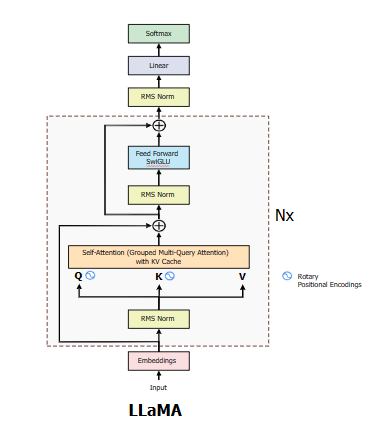

In [8]:
class FeedForward(nn.Module):
    def __init__(
        self,
        args: ModelArgs
    ):
        super().__init__()

        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        if args.ffn_dim_multiplier is not None:
            hidden_dim = int(args.ffn_dim_multiplier * hidden_dim)
        # Round the hidden_dim to the nearest multiple of the multiple_of parameter
        hidden_dim = args.multiple_of * ((hidden_dim + args.multiple_of - 1) // args.multiple_of)

        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x: torch.Tensor):
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        swish = F.silu(self.w1(x))
        # (B, Seq_Len, Dim) --> (B, Seq_Len, Hidden_Dim)
        x_V = self.w3(x)
        # (B, Seq_Len, Hidden_Dim) * (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Hidden_Dim)
        x = swish * x_V
        # (B, Seq_Len, Hidden_Dim) --> (B, Seq_Len, Dim)
        x = self.w2(x)
        return x

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        
        self.attention = SelfAttention(args)
        self.feed_forward = FeedForward(args)
        
        # PreNorm
        self.attention_norm = RMSNorm(self.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(self.dim, eps=args.norm_eps)
        
    def forward(self, x: torch.Tensor, start_pos: int, freqs_complex: torch.Tensor):        
        # attention
        ## (B, seq_len, dim) + (B, seq_len, dim) -> (B, seq_len, dim)
        y = self.attention_norm(x + self.attention(x, start_pos, freqs_complex))
        
        # feed forward
        ## (B, seq_len, dim) -> (B, seq_len, dim)
        y = self.ffn_norm(y + self.feed_forward(y))
        return y

In [10]:
class Transformer(nn.Module):

    def __init__(self, args: ModelArgs):
        super().__init__()

        assert args.vocab_size != -1, "Vocab size must be set"

        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.tok_embeddings = nn.Embedding(self.vocab_size, args.dim)

        self.layers = nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(EncoderBlock(args))

        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, self.vocab_size, bias=False)

        self.freqs_complex = precompute_theta_pos_frequencies(self.args.dim // self.args.n_heads, self.args.max_seq_len * 2, device=self.args.device)

    def forward(self, tokens: torch.Tensor, start_pos: int):
        # (B, Seq_Len)
        print('scout:', tokens.shape)
        batch_size, seq_len = tokens.shape
        # assert seq_len == 1, "Only one token at a time can be processed"

        # (B, Seq_Len) -> (B, Seq_Len, Dim)
        h = self.tok_embeddings(tokens)

        # Retrieve the pairs (m, theta) corresponding to the positions [start_pos, start_pos + seq_len]
        freqs_complex = self.freqs_complex[start_pos:start_pos + seq_len]
        
        # Consecutively apply all the encoder layers
        for layer in self.layers:
            h = layer(h, start_pos, freqs_complex)
        h = self.norm(h)
        output = self.output(h).float()
        return output

In [11]:
args = ModelArgs()
args.vocab_size = 1024
args

ModelArgs(dim=768, n_layers=4, n_heads=4, n_kv_heads=None, vocal_size=-1, multiple_of=4, ffn_dim_multiplier=None, norm_eps=1e-06, max_batch_size=32, max_seq_len=1024, device='cpu')

In [16]:
torch.set_default_tensor_type(torch.cuda.FloatTensor) if args.device == 'cuda' else torch.set_default_tensor_type(torch.FloatTensor)

In [17]:
model = Transformer(args)
x_dummy = torch.rand((args.max_batch_size, args.max_seq_len))

model

Transformer(
  (tok_embeddings): Embedding(1024, 768)
  (layers): ModuleList(
    (0-3): 4 x EncoderBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=768, out_features=768, bias=False)
        (wk): Linear(in_features=768, out_features=768, bias=False)
        (wv): Linear(in_features=768, out_features=768, bias=False)
        (wo): Linear(in_features=768, out_features=768, bias=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=768, out_features=2048, bias=False)
        (w2): Linear(in_features=2048, out_features=768, bias=False)
        (w3): Linear(in_features=768, out_features=2048, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=768, out_features=1024, bias=False)
)

In [18]:
args = ModelArgs()

x_dummy = torch.rand((args.max_batch_size, args.max_seq_len), device=args.device)

x_dummy

tensor([[0.7816, 0.3278, 0.9132,  ..., 0.2087, 0.0720, 0.6012],
        [0.7436, 0.4683, 0.2770,  ..., 0.8653, 0.2248, 0.2945],
        [0.7328, 0.7063, 0.3597,  ..., 0.2407, 0.6196, 0.4967],
        ...,
        [0.5713, 0.9808, 0.3165,  ..., 0.7311, 0.0645, 0.3199],
        [0.2580, 0.3368, 0.1721,  ..., 0.0085, 0.3915, 0.9030],
        [0.8165, 0.7742, 0.4873,  ..., 0.3979, 0.8503, 0.9920]])

In [19]:
model(x_dummy, 1023)

scout: torch.Size([32, 1024])


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

### INFERENCE CODE

In [ ]:
from typing import Optional
import torch
import time
from pathlib import Path
import json
from sentencepiece import SentencePieceProcessor
from tqdm import tqdm

In [ ]:
class LLaMA:
    def __init__(self, model:Transformer, tokenizer:SentencePieceProcessor, model_args:ModelArgs):
        self.model = model
        self.tokenizer = tokenizer
        self.model_args = model_args
        
    @staticmethod
    def build(checkpoints_dir: str, tokenizer_path: str, load_model: bool, max_seq_len: int, max_batch_size: int, device: str):
        prev_time = time.time()
        if load_model:
            checkpoints = sorted(Path(checkpoints_dir).glob('*.pth'))
            assert len(checkpoints) > 0, "No checkpoints found"
            chk_path = checkpoints[0]
            print(f"Loading model from {chk_path}")
            checkpoint = torch.load(chk_path, map_location='cpu')
            print(f"Loaded checkpoint in {time.time() - prev_time:.2f}s")
            prev_time = time.time()
        with open(Path(checkpoints_dir) / "params.json", "r") as f:
            params = ModelArgs(**json.load(f))
        model_args: ModelArgs = ModelArgs(
            max_batch_size=max_batch_size,
            max_seq_len=max_seq_len,
            device=device,
            **vars(params)
        )
        
        tokenizer = SentencePieceProcessor()
        tokenizer.Load(tokenizer_path)
        model_args.vocal_size = tokenizer.vocab_size()
        
        if device == 'cuda':
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
        else:
            torch.set_default_tensor_type(torch.FloatTensor)
            
        model = Transformer(model_args).to(device)
        
        if load_model:
            model.load_state_dict(checkpoint['model'])
            print(f"Loaded model in {time.time() - prev_time:.2f}s")

In [ ]:
args = ModelArgs()
args.vocab_size = 1024
args

In [ ]:
model = Modern_Transformer(args)
x_dummy = torch.rand((args.max_batch_size, args.max_seq_len))

model

In [ ]:
x_dummy.shape

In [ ]:
model(x_dummy, 1023)